In [ ]:
#!pip install openai pinecone langchain pypdf2 nltk
#!conda install -c conda-forge wordcloud -y


In [21]:
from pinecone import Pinecone
from typing import List, Dict, Set, Any, Callable
import collections as cl
import logging
import functools as ft
import itertools as it 

import numpy as np
from numpy import ndarray as array
from pandas import DataFrame

import os
import re

from openai import OpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from PyPDF2 import PdfReader

from nltk.tokenize import RegexpTokenizer

import dotenv

dotenv.load_dotenv()


True

In [22]:
openai_client = OpenAI()

pinecone_api = os.getenv("PINECONE_API")
print(pinecone_api)
pinecone_clinet = Pinecone(api_key=pinecone_api)

index_name = "javascript-db"
index = pinecone_clinet.Index(index_name)


pcsk_6CenEX_3J21gdTeG8xq7rN4HZr7ySyht7CBoZZRAZH2K3pxfXgjXu8jUF6p2sFS12VF4ZB


In [23]:

logger: Any = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
info: Callable = logger.info
print("Hello")
logger.warning("Warning")
info = logger.warning
# logger.info("Info")
info("Info")


def var_info(a: Any) -> Any:
  """
  Args:
    a: Any  The object to print information about.
  Returns:
    Any  The first 10 rows of the object.
  Prints the type and shape of the object.
  If the object is a DataFrame, it prints the columns and data types.
  Returns the first 10 rows of the object.
  """
  type_a: Type = type(a)
  info(type_a, a.shape, sep="\n")
  if type_a == DataFrame:
    info(a.columns, a.dtypes, sep="\n")
  return a[:10]


# %% [markdown]
# # Data
# ## Loading Data
# The documents from the positive and negative folders were loaded as strings and stored in a list.  A list of labels was created indicating whether the document was from the positive folder or the negative folder.

# %%

from nltk.tokenize import RegexpTokenizer


# ## Tokenising
# Contractions were expanded, 's was removed, and the text of each document was tokenized.


reg_tokenizer = RegexpTokenizer(r"[a-z]\w*(?:'\w+)*")

def token(string):
  return reg_tokenizer.tokenize(string.lower())

import contractions

def tokenize(t: str) -> List[str]:
  """
  Tokenizes a string.
  Args:
    t: str  The string to tokenize.
  Returns:
    List[str]  A list of tokens.
  """
  t = t.lower()
  t = contractions.fix(t)
  return token(t)

# %% [markdown]
# ## Lemmatising
# Stopwords were removed from each list of tokens and the tokens were lemmatised.

# %%
import nltk

# expand contractions
# tokens_text_pos = list(map(contractions.fix, tokens_text_pos))
# tokens_text_neg = list(map(contractions.fix, tokens_text_neg))

# not_words are stopwords and internet words
not_words: Set[str] = (set(nltk.corpus.stopwords.words('english')).difference(set(("not", "no"))))

for word in not_words:
  if word.startswith("n"):
    info(word)

# not_words: Set[str] = set(nltk.corpus.stopwords.words( 'english')).union(set(("href", "lt", "gt", "br", "p")))

info(not_words)


# apply lemmatization to the article text using NLTK
lemmatizer: Any = nltk.stem.WordNetLemmatizer()

parts_of_speech: str = "arsvn"


def lemmatize(w: str) -> str:
  """
  Lemmatizes a word as all parts of speech including nouns, verbs, adjectives, and adverbs
  Args:
    w: str  A word to be lemmatized
  Returns:
    str  The lemmatized word
  """
  for part_of_speech in parts_of_speech:
    w = lemmatizer.lemmatize(w, pos=part_of_speech)
  return w


def lemmatize_words(tokens: List[str]) -> List[str]:
  """
  Lemmatizes a list of words.
  Args:
    tokens: List[str]  A list of words to be lemmatized.
  Returns:
    List[str]  A list of lemmatized words.
  """
  return list(map(lemmatize, filter(lambda x: x not in not_words, tokens)))


def prepare_text(string):
  string = tokenize(string)
  return lemmatize_words(string)

prepare_text("Hello.  This is a sentence, written in English.")


Warning
Info
needn't
needn
now
nor
{'have', 'before', 'about', "you'll", 'he', 'further', 'of', 'in', 'y', 'aren', 'himself', 'whom', 'here', 'do', 'with', 'you', "needn't", 'doing', 'ourselves', 'your', 'didn', 'which', 'too', 'where', "you'd", 'an', 'while', 'shouldn', 'weren', 'herself', "hadn't", 'but', 'why', 'for', 'both', 'it', 'after', 'there', 'won', 'and', 'that', 'yourself', 'than', 'isn', "you're", "mustn't", 'themselves', 't', 'what', 'has', "mightn't", 'the', 'having', 'she', 'same', 'each', "isn't", 'should', 'very', 'them', 'hadn', "don't", 'him', 'until', 'up', 'needn', 'they', 'most', 've', "weren't", 'hers', 'just', "that'll", 'had', 'such', 'now', 'd', 'ma', 'am', 'theirs', 'at', 'will', "doesn't", 'to', 'were', 'between', 'all', 'nor', 'i', 'we', 'haven', 'so', 'his', 'other', 'does', 'being', 'off', 'wasn', 'her', 'how', 'these', "she's", "it's", 'couldn', 'doesn', 'me', "hasn't", "should've", 'our', 'own', 'are', 'by', 'against', 'over', "shouldn't", 'shan', "won

Hello


['hello', 'sentence', 'write', 'english']

In [30]:
import pdfminer
import PyPDF2
import os

def convert_pdf_to_text(pdf_path: str) -> str:
    """
    Extract plain text from a PDF using pdfminer.six.
    """
    # convert pdf to text using PyPDF2
    pdf_reader = PyPDF2.PdfReader(pdf_path)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

def save_text_to_file(text: str, output_path: str) -> None:
    """
    Save extracted text to a .txt file.
    """
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(text)

def convert_pdf_to_txt_file(pdf_path: str, output_txt_path: str, start_ch, end_ch) -> None:
    print(f"Extracting text from: {pdf_path}")
    text = convert_pdf_to_text(pdf_path)
    end_ch = len(text) - end_ch
    print(f"Saving to: {output_txt_path}")
    save_text_to_file(text[start_ch:end_ch], output_txt_path)

    print("Done!")
    return text[start_ch:end_ch]

# Example usage
if __name__ == "__main__":
    input_pdf = "1.pdf"
    output_txt = "javascript_book_1.txt"
    text = ""

    if os.path.exists(input_pdf):
        text = convert_pdf_to_txt_file(input_pdf, output_txt, 50*500, 10*500+41220)
        text_tokens = prepare_text(text)
        text = " ".join(text_tokens)
    else:
        print(f"File not found: {input_pdf}")


Extracting text from: 1.pdf
Saving to: javascript_book_1.txt
Done!


In [14]:
# Reading pdf and creating text 

faq_database = ["""
    "What is your return policy?": "Our return policy allows customers to return products within 30 days of purchase. Items must be in their original condition and packaging. To initiate a return, visit our return portal and provide your order number and email address.",

    "How do I track my order?": "You can track your order by using the tracking number provided in the shipment confirmation email. Alternatively, you can log in to your account and go to the 'Order History' section to find the tracking link.",

    "What payment methods do you accept?": "We accept all major credit cards (Visa, MasterCard, American Express), PayPal, and Apple Pay. For corporate accounts, we also offer invoicing options. Please contact support for more information on setting up a corporate account.",

    "Can I change or cancel my order after it’s been placed?": "Once an order has been placed, we are unable to modify it directly. However, you can cancel your order within the first hour of placing it through the 'My Orders' section of your account. After that, you’ll need to wait for the order to be delivered and then initiate a return.",

    "What are your shipping options?": "We offer standard, expedited, and overnight shipping. Standard shipping takes 5-7 business days, while expedited shipping takes 2-3 business days. Overnight shipping ensures delivery by the next business day. International shipping options are also available, with delivery times varying by destination.",

    "How do I reset my account password?": "To reset your password, go to the login page and click on 'Forgot Password'. You will receive an email with instructions to reset your password. If you don't see the email, check your spam folder or contact customer support for help.",

    "Do you ship internationally?": "Yes, we ship to select international destinations. International shipping costs and delivery times vary depending on the destination. You can calculate the shipping costs at checkout after providing your address.",

    "What do I do if I receive a damaged or defective product?": "If you receive a damaged or defective product, please contact our customer support within 48 hours of receiving the item. We will provide instructions on how to return the product or arrange for a replacement. Make sure to include photos of the damaged item and packaging for faster processing.",

    "How do I contact customer support?": "You can contact our customer support via email at support@ourcompany.com, or by calling our support line at 1-800-123-4567 during business hours (9 AM to 5 PM, Monday to Friday). We also offer live chat support on our website.",

    "Can I use multiple discount codes on a single order?": "No, our system only allows one discount code per order. However, you can apply store credit or a gift card in addition to a discount code at checkout.",

    "How do I update my shipping address after placing an order?": "If your order has not yet been processed, you can update your shipping address by logging into your account and navigating to the 'My Orders' section. If the order has already been processed or shipped, you will need to contact customer support to discuss possible options.",

    "What should I do if I never received my order?": "If your order has not arrived by the estimated delivery date, first check the tracking information. If the tracking shows the item was delivered but you didn't receive it, contact customer support so we can investigate and resolve the issue.",

    "Do you offer gift wrapping?": "Yes, we offer gift wrapping for an additional fee. You can select the gift wrapping option at checkout, and you can also include a personalized message with the gift.",

    "Can I return a product after 30 days?": "Unfortunately, returns are only accepted within 30 days of the purchase date. If you have extenuating circumstances, please contact customer support to discuss possible exceptions on a case-by-case basis.",

    "What are your business hours?": "Our customer support team is available from 9 AM to 5 PM, Monday through Friday, excluding holidays. Our website is available for orders 24/7.",

    "How do I subscribe to your newsletter?": "To subscribe to our newsletter, scroll to the bottom of our homepage and enter your email in the subscription box. You’ll receive exclusive offers, product updates, and company news directly to your inbox.",

    "What is your warranty policy?": "We offer a one-year warranty on all our products. The warranty covers manufacturing defects but does not cover damage caused by misuse, accidents, or normal wear and tear. To file a warranty claim, contact our customer support team with your order details and a description of the issue.",

    "How can I become a reseller of your products?": "We welcome reseller partnerships! If you're interested in becoming a reseller, please contact our sales team at sales@ourcompany.com with details about your business, and we’ll get back to you with more information.",

    "Do you offer student discounts?": "Yes, we offer a 10 discount for students. To get the discount, sign up with your valid student email, and we will verify your status. After verification, you will receive a unique discount code to use at checkout.",

    "Can I expedite the shipping of my order?": "Yes, you can select expedited or overnight shipping at checkout. Expedited shipping typically takes 2-3 business days, while overnight shipping ensures delivery by the next business day. Please note that expedited shipping costs more than standard shipping."
"""]


In [19]:
text = " ".join(faq_database)
text2 = prepare_text(text)
print(text2)


['return', 'policy', 'return', 'policy', 'allow', 'customer', 'return', 'product', 'within', 'day', 'purchase', 'item', 'must', 'original', 'condition', 'package', 'initiate', 'return', 'visit', 'return', 'portal', 'provide', 'order', 'number', 'email', 'address', 'track', 'order', 'track', 'order', 'use', 'track', 'number', 'provide', 'shipment', 'confirmation', 'email', 'alternatively', 'log', 'account', 'go', 'order', 'history', 'section', 'find', 'track', 'link', 'payment', 'method', 'accept', 'accept', 'major', 'credit', 'card', 'visa', 'mastercard', 'american', 'express', 'paypal', 'apple', 'pay', 'corporate', 'account', 'also', 'offer', 'invoice', 'option', 'please', 'contact', 'support', 'information', 'set', 'corporate', 'account', 'change', 'cancel', 'order', 'place', 'order', 'place', 'unable', 'modify', 'directly', 'however', 'cancel', 'order', 'within', 'first', 'hour', 'place', 'order', 'section', 'account', 'need', 'wait', 'order', 'deliver', 'initiate', 'return', 'ship'

209
[('order', 20), ('ship', 19), ('support', 13), ('customer', 10), ('contact', 10), ('return', 9), ('offer', 9), ('product', 8), ('day', 8), ('business', 8), ('receive', 8), ('email', 7), ('discount', 7), ('track', 6), ('account', 6), ('expedite', 6)]
16


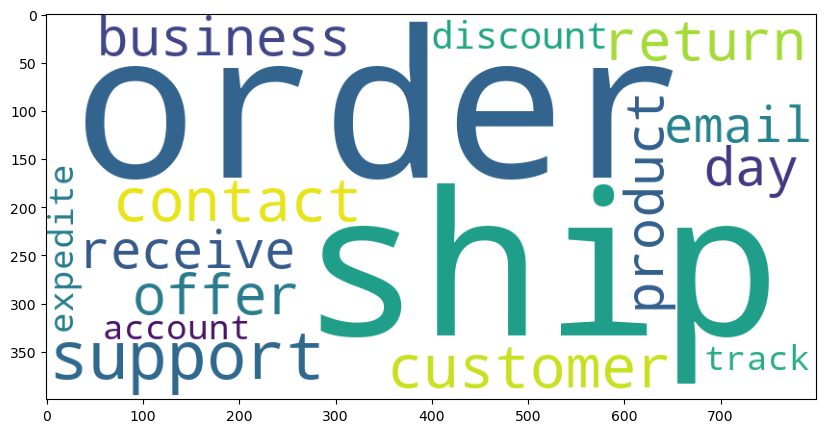

In [20]:

from typing import Tuple
counter: Any = cl.Counter()

counter.update(text2)

print(len(counter))
sorted_words: List[Tuple[str, int]] = list(it.takewhile(lambda x: x[1] > 5, counter.most_common()))
sorted_words_50: List[Tuple[str, int]] = sorted_words[:50]
print(sorted_words_50)


vocabulary: List[str] = list(map(lambda x: x[0], sorted_words))

print(len(vocabulary))

vocabulary_file: str = "vocab.txt"
with open(vocabulary_file, "w") as f:
    f.write("\n".join(vocabulary))


# %% [markdown]
# ## Wordcloud
# A wordcloud of the top 50 words was created.

# %%
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def show_wordcloud(token_dict: Dict[str, int]):
  """
  Shows a wordcloud of the top 50 words.
  Args:
    token_dict: Dict[str, int]  A dictionary of words and their frequencies.
  """
  wordcloud: Any = WordCloud(width=800, height=400,
                             background_color="white").generate_from_frequencies(token_dict)

  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud)
  plt.show()


show_wordcloud(dict(sorted_words_50))


In [18]:
# chunking text
def chunk_text(book_texts: List[str], chunk_size: int = 1000, overlap: int = 200) -> List[str]:
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
    chunks = []
    for text in book_texts:
        chunks.extend(splitter.split_text(text))
    return chunks


In [35]:
chunks = chunk_text([text], chunk_size=2000)


In [36]:
print(chunks)
print(len(chunks))


['purposes. we\nbelieve make image... computer is\nnot really like us. projection slim part ourselves:\nthat portion devote logic, order, rule, clarity.”\n\n—ellen ullman, close machine: technophilia its\ndiscontents\n\nintroduction\n\nthis book instruct computers. computer common\nas screwdriver today, quite bite complex, make them\ndo want not always easy.\n\nif task computer common, well-understood one,\nsuch show email act like calculator, open the\nappropriate application get work. unique open-ended tasks,\nthere often no appropriate application.\n\nthat program may come in. program act con-\nstructing program—a set precise instruction tell computer do.\nbecause computer dumb, pedantic beasts, program fundamentally\ntedious frustrating.\n\nfortunately, get fact—and maybe even enjoy rigor\nof think term dumb machine deal with—programming be\nrewarding. allow thing second would take forever by\nhand. way make computer tool thing could not do\nbefore. top that, make wonderful game pu

In [22]:
# creating embedding vector
def get_embeddings(texts: List[str]) -> List[List[float]]:
    response = openai_client.embeddings.create(
        model="text-embedding-ada-002",
        input=texts
    )
    return [e.embedding for e in response.data]


In [23]:
embeddings = get_embeddings(chunks)


In [24]:
len(embeddings[0])


1536

In [25]:
def upload_to_pinecone(texts: List[str], embeddings: List[List[float]]) -> None:
    for i, (text, embedding) in enumerate(zip(texts, embeddings)):
        index.upsert([
            (f"chunk-{i}", embedding, {"text": text})
        ])


In [26]:
upload_to_pinecone(chunks, embeddings=embeddings)


In [28]:
#dfuntion to find the most similar chunk
def retrieve_similiar_chunck(query_embedding, index, top_k=1):
    response = index.query(
        vector=query_embedding,
        top_k=top_k,
        include_values = False,
        include_metadata = True
    )
    return response['matches'][0]['metadata']['text']


In [29]:
def prompt_builder(system_message, context):
    return system_message['content'].format(context)


In [30]:
# creating system prompt for openAI
system_prompt = {
                    "role" : "system",
                    "content": """
                    we will define what system should do
                    Answer question about JavaScript using at least 50 percent of the provided context.
                    answer primarily based on the context and specify which parts are not based on context
                    Context: {}
                    """,
    
                }


In [31]:
def rag_chatbot(query, openai_client):
    
    # Step 1: encode the query
    query_embeddings = get_embeddings(query)
    
    # Step 2: find the most similar chunks
    similar_chunk = retrieve_similiar_chunck(query_embeddings, index, top_k=1)
    
    augmented_prompt = prompt_builder(system_prompt, similar_chunk)
    
    messages = [
        {"role": "system", "content":augmented_prompt},
        {"role": "user", "content":query}
    ]
    
    response = openai_client.chat.completions.create(
      model="gpt-4o",
      messages=messages,
      max_tokens=3000
    )
    
    return response.choices[0].message.content, augmented_prompt


In [32]:
def ask_chatgpt(message, openai_client):
    messages = [
        {"role": "system", "content":"You are an objective context and answer evaluation answer."},
        {"role": "user", "content":message}
    ]
    
    response = openai_client.chat.completions.create(
      model="gpt-4o",
      messages=messages,
      max_tokens=3000
    )
    
    return response.choices[0].message.content


In [33]:
query_embedding_1 = "How do I program a for loop in JavaScript so that I can run part of a program many times?"


In [34]:
response, prompt = rag_chatbot(query_embedding_1, openai_client=openai_client)

print("Prompt", prompt, sep="\n")
print("Response", response, sep="\n")


Prompt

                    we will define what system should do
                    Answer question about JavaScript using at least 50 percent of the provided context.
                    answer primarily based on the context and specify which parts are not based on context
                    Context: this not boring—it ineffective. new problem often require new
solutions. field program young still develop rapidly, and
it vary enough room wildly different approaches. are
many terrible mistake make program design, go ahead
and make least understand them. sense a
good program look like develop practice, not learn list of
rules.

why language matters

in beginning, birth computing, no program lan-
guages. program look something like this:

00110001 00000000 00000000
00110001 00000001 00000001
00110011 00000001 00000010
01010001 00001011 00000010
00100010 00000010 00001000
01000011 00000001 00000000
01000001 00000001 00000001
00010000 00000010 00000000
01100010 00000000 00000000

this pr

In [26]:
prompt = "Evaluate this context and this answer based on this question. Give scores out of 100 for Correctness of Context, Use of Context, Completeness, and Clarity and Relevance." + prompt + response
print(ask_chatgpt(prompt, openai_client=openai_client))


**Correctness of Context: 90/100**

The context provided gives a brief history of programming languages and explains the evolution from machine-level programming to modern programming languages like JavaScript. The context is generally accurate, though it has grammatical issues and typographical errors that could impact understanding.

**Use of Context: 70/100**

The answer does relate to the context in terms of explaining control flow, mentioning constructs that automate tasks that were previously manual and tedious. However, it doesn't directly engage with the specific examples given in the context around adding numbers with loops. The historical perspective of manual programming versus the automated for loop in JavaScript could have been more directly referenced.

**Completeness: 85/100**

The answer is complete in explaining the mechanics of a JavaScript for loop and shows how it simplifies iterative processes, echoing the context's idea of programming languages providing convenien